In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = True

In [3]:
# some important parameters
pre_day = 5
window_size = 12*24*7 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    #"metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    #"metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

Writing HTML: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]

Visualization saved at visualization/raw_data/*.html


In [7]:
failure_sessions = failure_sessions[failure_sessions['maintenance'] == False]

### Data Cleaning

In [8]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (32, 6)
Excluded 2 periods, remaining data size: 27
Excluded 2 periods, remaining data size: 27
failure_sessions shape: (27, 7)


In [9]:
visualize_failure_timeline(filtered_sessions)

In [10]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

In [11]:
if performe_visualization:
    # Visualize the filtered data
    visualize_hourly_mean_values(filtered_data, failure_sessions, feature_cols, 'visualization', 'filtered_data')

Writing HTML: 100%|██████████| 16/16 [00:41<00:00,  2.62s/it]

Visualization saved at visualization/filtered_data/*.html


### Anomoly Detection

In [12]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

### Missing Value Imputation

In [13]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [14]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                  Column Aggregation
0          metric.AC_VOLTAGE_AB.MEASURED        mean
1          metric.AC_VOLTAGE_BC.MEASURED        mean
2          metric.AC_VOLTAGE_CA.MEASURED        mean
3             metric.DC_VOLTAGE.MEASURED        mean
4               metric.AC_POWER.MEASURED        mean
5  metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6  metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7  metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8     metric.DC_VOLTAGE.MEASURED_missing        mean
9       metric.AC_POWER.MEASURED_missing        mean


In [15]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_hourly_mean_values(downsampled_data, failure_sessions, extended_feature_cols, 'visualization', 'downsampled_data')

Writing HTML: 100%|██████████| 16/16 [01:16<00:00,  4.80s/it]

Visualization saved at visualization/downsampled_data/*.html


In [16]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 12)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 12)


### Data Labeling

In [17]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 6148
Total rows: 853553


### Feature Engineering

In [18]:
downsampled_data['hour_of_day'] = downsampled_data['event_local_time'].dt.hour
downsampled_data['month_of_year'] = downsampled_data['event_local_time'].dt.month
extended_feature_cols += ['hour_of_day', 'month_of_year']


In [19]:
if performe_visualization:
    visualize_hourly_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data')

Writing HTML: 100%|██████████| 16/16 [01:22<00:00,  5.18s/it]

Visualization saved at visualization/processed_data/*.html


### Split Dataset

In [20]:
train_df = downsampled_data[downsampled_data['event_local_time'] <= pd.Timestamp('2023-12-15')].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > pd.Timestamp('2023-12-15')) & (imputed_df['event_local_time'] <= pd.Timestamp('2024-07-31'))].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > pd.Timestamp('2024-07-31')].copy()

C:\Users\USER\AppData\Local\Temp\ipykernel_1944\4114155479.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [21]:
#train_df, test_df = train_test_split_on_time(imputed_df, 0.3)
#val_df, test_df = train_test_split_on_time(test_df, 0.3)

In [22]:
extended_feature_cols

['metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_of_day',
 'month_of_year']

### Standardization

In [23]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day', 'month_of_year']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [24]:
if performe_visualization:
    visualize_hourly_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data')
    visualize_hourly_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data')
    visualize_hourly_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data')

Writing HTML: 100%|██████████| 16/16 [00:41<00:00,  2.58s/it]


Visualization saved at visualization/train_data/*.html


Writing HTML: 100%|██████████| 16/16 [00:46<00:00,  2.92s/it]


Visualization saved at visualization/val_data/*.html


Writing HTML: 100%|██████████| 16/16 [00:28<00:00,  1.78s/it]

Visualization saved at visualization/test_data/*.html


### Create Dataset/Data Loader

In [25]:
stride = 1
window_size = 2*24*7 # 30 minutes * 24 * 7 = 1 week

In [26]:
train_df[train_df.isna().any(axis=1)]

,event_local_time,device_name,metric.AC_VOLTAGE_AB.MEASURED,metric.AC_VOLTAGE_BC.MEASURED,metric.AC_VOLTAGE_CA.MEASURED,metric.DC_VOLTAGE.MEASURED,metric.AC_POWER.MEASURED,metric.AC_VOLTAGE_AB.MEASURED_missing,metric.AC_VOLTAGE_BC.MEASURED_missing,metric.AC_VOLTAGE_CA.MEASURED_missing,metric.DC_VOLTAGE.MEASURED_missing,metric.AC_POWER.MEASURED_missing,label,hour_of_day,month_of_year


In [27]:
positive_train_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=1)
negative_train_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=1)

Processing devices: 100%|██████████| 16/16 [00:01<00:00,  8.88it/s]


In [28]:
from torch.utils.data import DataLoader


train_ds = combine_dataset([positive_train_ds, negative_train_ds])
del positive_train_ds, negative_train_ds

val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:01<00:00, 13.68it/s]


In [29]:
train_ds.X.shape

torch.Size([380934, 336, 12])

In [30]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    378524
 1.0      2410
 dtype: int64,
 0.0    423444
 1.0      3360
 dtype: int64,
 0.0    257643
 1.0      1920
 dtype: int64)

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler, RandomSampler
import torch

num_samples = int(len(train_ds)*0.1 ) # 10% of the training dataset size

# 假設 y 是樣本的 label 張量
class_sample_count = pd.value_counts(train_ds.y.numpy())
weights = 1. / class_sample_count
sample_weights = weights[train_ds.y.numpy()].to_numpy() # 每個樣本對應的抽樣權重

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=num_samples,
    replacement=True
)
print(weights, num_samples)

0.0    0.000003
1.0    0.000415
dtype: float64 38093


In [ ]:
random_sampler = RandomSampler(val_ds, num_samples=int(len(val_ds)*0.1), replacement=True)

In [33]:
batch_size = 2**9

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=balanced_sampler,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, sampler=random_sampler, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [34]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 建議先用較溫和的 pos_weight（例：5），再用驗證集掃描最佳值
pos_weight_value = 2.0
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], dtype=torch.float)).to('cuda')


In [35]:
#model.load_state_dict(torch.load(r'model\0812_0003\epoch_15.pth', weights_only=True))

In [53]:
log = train_loop(
    model, train_loader, val_loader, 
    log_interval=25, 
    num_epochs=20, 
    optimizer=optimizer, 
    criterion=criterion,
    save_interval=5,
    save_path=r'model\0813_0344'
)

Model moved to cuda
Resuming training from epoch 51
[Epoch 51/20] Step 0/75 - Loss: 0.1229
[Epoch 51/20] Step 25/75 - Loss: 0.1833
[Epoch 51/20] Step 50/75 - Loss: 0.2610
🔁 Epoch 51 finished. Avg Train Loss: 0.1574
✅ Validation Loss: 0.2435 | Accuracy: 94.99% | AUC-PR: 0.0120
[Epoch 52/20] Step 0/75 - Loss: 0.1336
[Epoch 52/20] Step 25/75 - Loss: 0.1349
[Epoch 52/20] Step 50/75 - Loss: 0.0842
🔁 Epoch 52 finished. Avg Train Loss: 0.1283
✅ Validation Loss: 0.2468 | Accuracy: 95.83% | AUC-PR: 0.0106
[Epoch 53/20] Step 0/75 - Loss: 0.0783
[Epoch 53/20] Step 25/75 - Loss: 0.0921
[Epoch 53/20] Step 50/75 - Loss: 0.1529
🔁 Epoch 53 finished. Avg Train Loss: 0.1137
✅ Validation Loss: 0.2292 | Accuracy: 97.06% | AUC-PR: 0.0110
[Epoch 54/20] Step 0/75 - Loss: 0.1055
[Epoch 54/20] Step 25/75 - Loss: 0.1162
[Epoch 54/20] Step 50/75 - Loss: 0.1566
🔁 Epoch 54 finished. Avg Train Loss: 0.0999
✅ Validation Loss: 0.3019 | Accuracy: 95.26% | AUC-PR: 0.0093
[Epoch 55/20] Step 0/75 - Loss: 0.0930
[Epoch 55

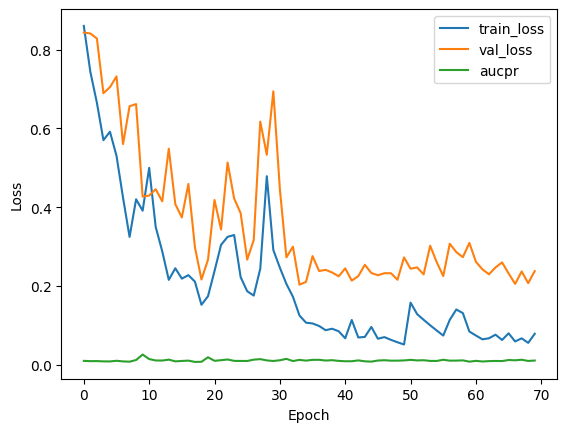

In [62]:
import matplotlib.pyplot as plt
#log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.plot(log['aucpr'], label='aucpr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [63]:
model.load_state_dict(torch.load(r'model\0813_0344\epoch_70.pth', weights_only=True))

<All keys matched successfully>

Performance on Training Set:


Testing: 100%|██████████| 75/75 [00:09<00:00,  7.99it/s]


🔍 Test Loss: 0.0562 | Accuracy: 98.56%
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     19077
     Failure       0.97      1.00      0.99     19016

    accuracy                           0.99     38093
   macro avg       0.99      0.99      0.99     38093
weighted avg       0.99      0.99      0.99     38093

[[18530   547]
 [    0 19016]]
ROC AUC: 0.9970


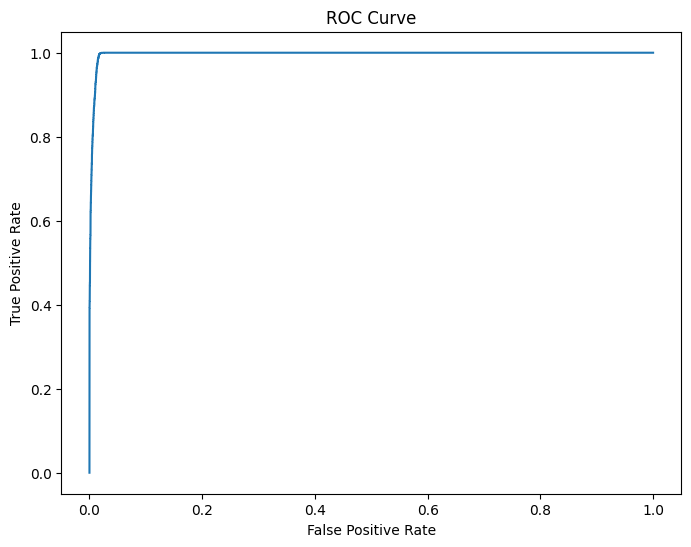

In [64]:
print("Performance on Training Set:")
evaluate_model(model, train_loader, best_threshold=0.5, criterion=criterion)

In [65]:
val_loader_for_eval = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

In [66]:
trues, predictions, outputs = test_loop(model, val_loader_for_eval, device='cuda', criterion=criterion)

Testing: 100%|██████████| 834/834 [00:39<00:00, 20.94it/s]

🔍 Test Loss: 0.2361 | Accuracy: 98.18%


In [67]:
from sklearn.metrics import precision_recall_curve, f1_score

# y_val: 驗證集真實標籤 (0/1)
# y_val_scores: 模型輸出的機率（sigmoid 後）或 logits
precisions, recalls, thresholds = precision_recall_curve(trues, outputs)

# 計算 F1
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)
print("Precision:", precisions[best_idx])
print("Recall:", recalls[best_idx])
print("F1:", f1_scores[best_idx])


Best threshold: 0.9035845
Precision: 0.05986773407587887
Recall: 0.05119047619047619
F1: 0.055190112149086396


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99    423444
     Failure       0.06      0.05      0.06      3360

    accuracy                           0.99    426804
   macro avg       0.53      0.52      0.52    426804
weighted avg       0.99      0.99      0.99    426804

[[420743   2701]
 [  3188    172]]
ROC AUC: 0.5139


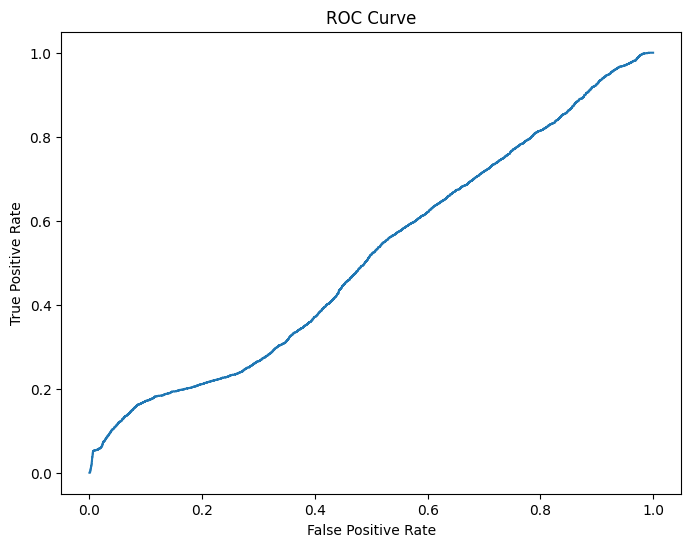

In [70]:
predictions = (outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
generate_report(trues, predictions, outputs)

Performance on Test Set:


Testing: 100%|██████████| 507/507 [00:27<00:00, 18.37it/s]


🔍 Test Loss: 0.2282 | Accuracy: 98.70%
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99    257643
     Failure       0.00      0.00      0.00      1920

    accuracy                           0.99    259563
   macro avg       0.50      0.50      0.50    259563
weighted avg       0.99      0.99      0.99    259563

[[256179   1464]
 [  1920      0]]
ROC AUC: 0.5134


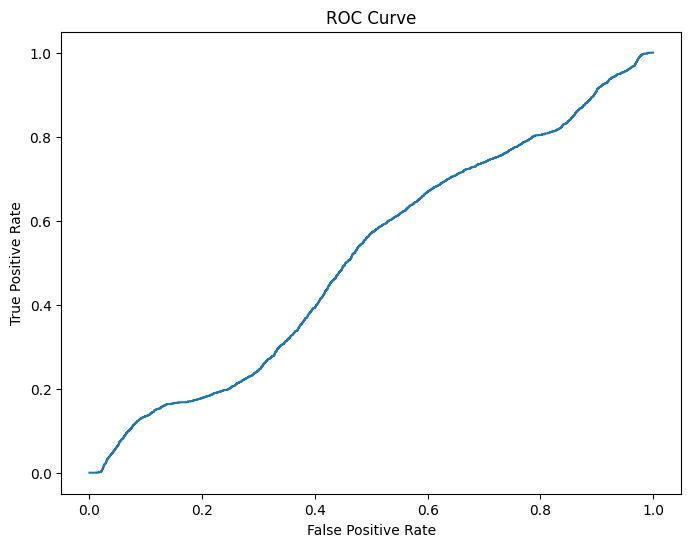

In [69]:
print("Performance on Test Set:")
evaluate_model(model, test_loader, best_threshold=best_threshold, device='cuda', criterion=criterion)